In [1]:
import glob
import json
import os
from collections import defaultdict

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import numpy as np
import pandas as pd

In [92]:
RESULTS_DIR = 'results/xdn_fuselog'

In [93]:
data = defaultdict(list)
for filename in os.listdir(RESULTS_DIR):
    if not (filename.startswith('latency_') and filename.endswith('.json')): continue
    with open(os.path.join(RESULTS_DIR, filename), 'r') as writer:
        latency_results = json.load(writer)
        for key in latency_results:
            data[key].extend(latency_results[key])

data = {key: pd.Series(data[key]) * 1000 for key in data}
data

{'order': 0        47.081709
 1        47.196388
 2        36.297083
 3        47.112703
 4        40.038586
            ...    
 14343    35.665035
 14344    25.565624
 14345    47.399759
 14346    42.800665
 14347    35.831451
 Length: 14348, dtype: float64,
 'payment': 0        29.080629
 1        19.779444
 2        16.963243
 3        16.334057
 4        16.064405
            ...    
 13592    16.865969
 13593    34.839153
 13594    33.059835
 13595    26.820898
 13596    16.294718
 Length: 13597, dtype: float64,
 'order_status': 0       12.926817
 1       56.421757
 2       10.443926
 3       16.264677
 4        6.740570
           ...    
 1342     6.567478
 1343     6.366730
 1344    44.393063
 1345    15.788317
 1346     6.956339
 Length: 1347, dtype: float64,
 'stock_level': 0         8.940458
 1        58.123350
 2         7.494211
 3        10.960102
 4        66.781282
            ...    
 1253    162.535429
 1254      9.546757
 1255    150.474310
 1256      5.990028
 1257

# Plots

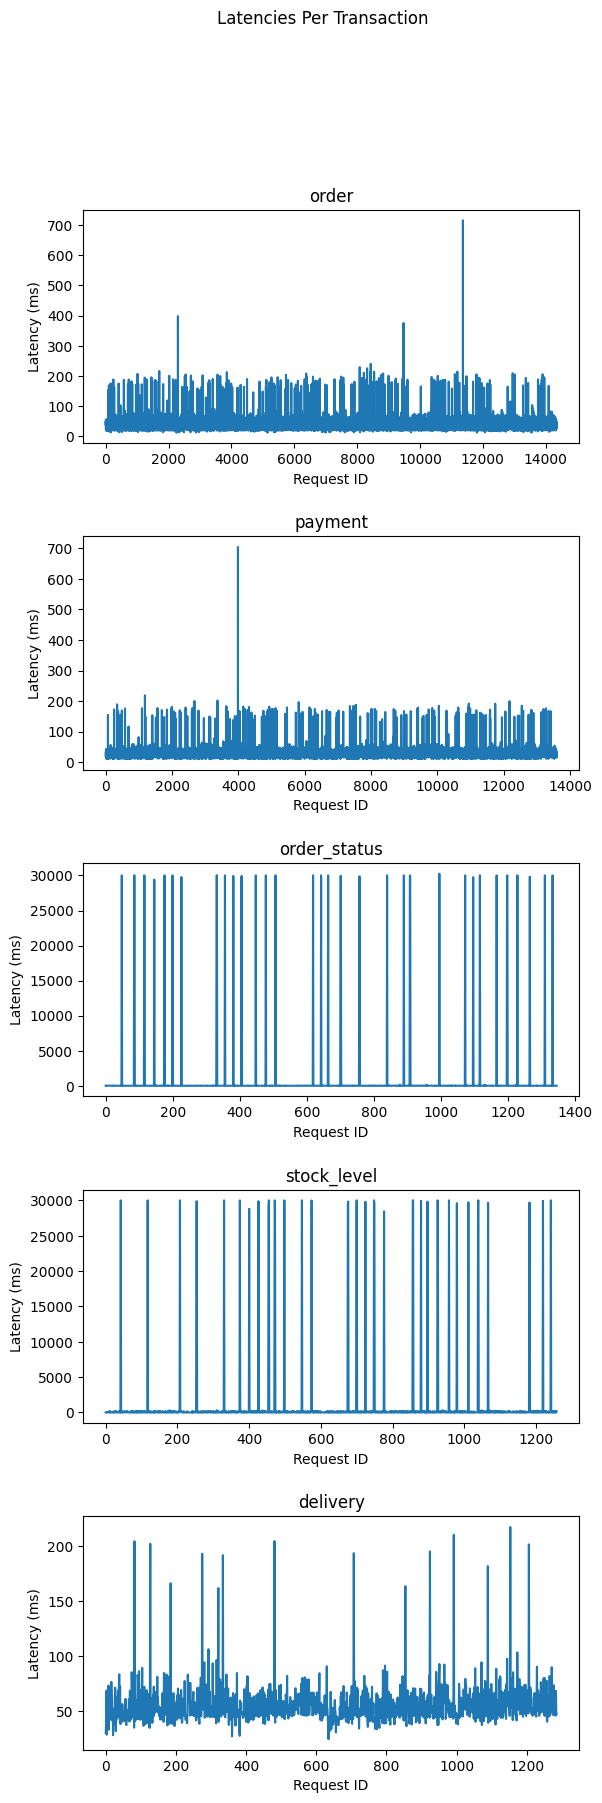

In [94]:
figure, axes = plt.subplots(nrows=5)
figure.set_figheight(20)
figure.subplots_adjust(hspace=0.4)
figure.suptitle('Latencies Per Transaction')
for i, key in enumerate(data):
    axes[i].plot(data[key])
    axes[i].set_title(key)
    axes[i].set_xlabel('Request ID')
    axes[i].set_ylabel('Latency (ms)')
figure.savefig(os.path.join(RESULTS_DIR, 'latency.png'))

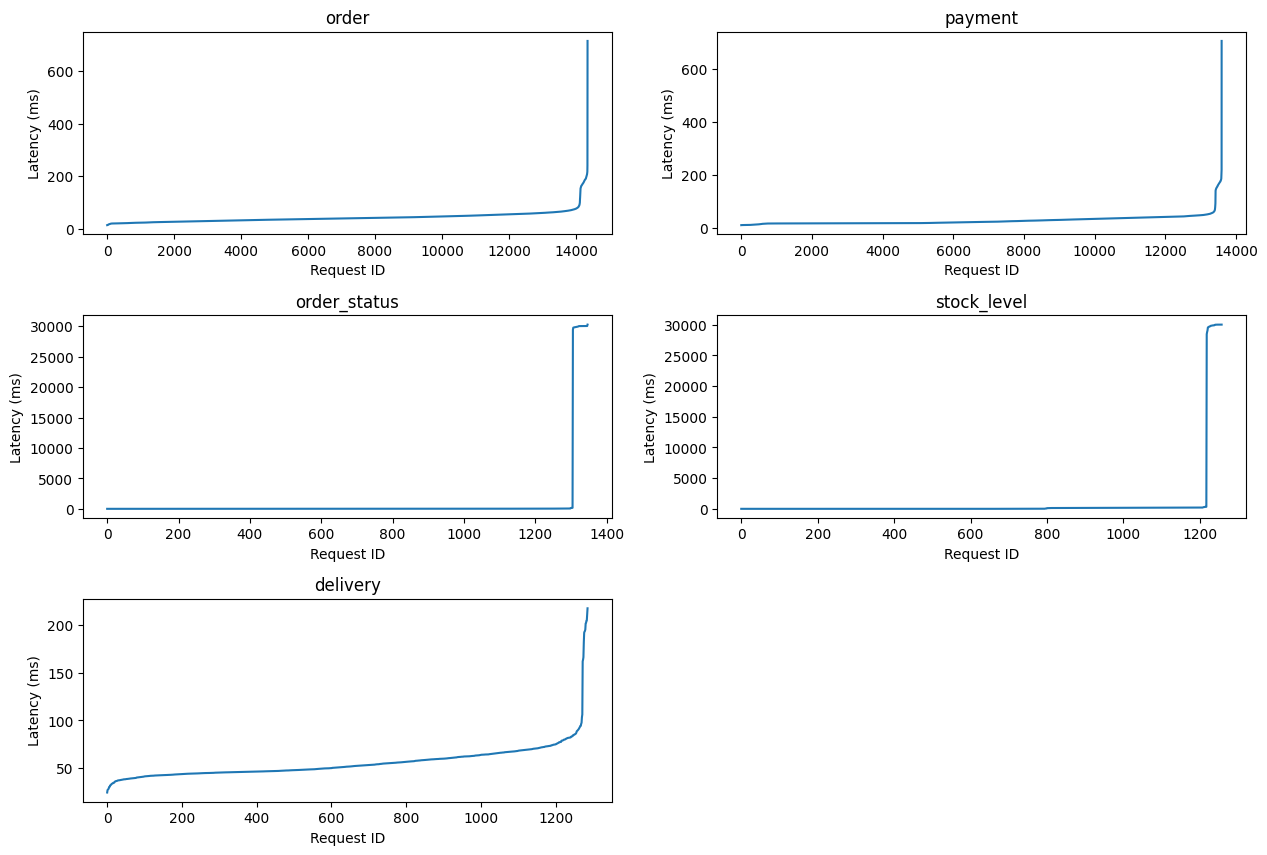

In [95]:
figure, axes = plt.subplots(3, 2)
figure.set_figheight(10)
figure.set_figwidth(15)
figure.subplots_adjust(hspace=0.4)
# figure.suptitle('Sorted Latencies Per Transaction')
for i, key in enumerate(data):
    axes[i//2, i%2].plot(sorted(data[key]))
    axes[i//2, i%2].set_title(key)
    axes[i//2, i%2].set_xlabel('Request ID')
    axes[i//2, i%2].set_ylabel('Latency (ms)')
figure.delaxes(axes[2,1])
figure.savefig(os.path.join(RESULTS_DIR, 'sorted_latency.png'))

# Metrics

In [85]:
latency_quantiles = [[key,
                      round(data[key].quantile(q=0.5), 4),
                      round(data[key].quantile(q=0.9), 4),
                      round(data[key].quantile(q=0.95), 4),
                      round(data[key].quantile(q=0.99), 4)]
                     for key in data]
df = pd.DataFrame(latency_quantiles, columns=['Transaction', 'P50', 'P90', 'P95', 'P99'])
df.to_csv(os.path.join(RESULTS_DIR, 'latency_quantiles.csv'), index=False)
df

,Transaction,P50,P90,P95,P99
0,order,38.9668,58.9928,65.9165,171.3548
1,payment,22.0232,41.0785,46.5157,152.3863
2,order_status,7.2920,35.4805,44.3365,30015.8597
3,stock_level,7.1014,184.2467,203.7459,30014.8845
4,delivery,51.6427,71.3046,79.6243,162.1549


In [86]:
data['order'].describe()

count    14348.000000
mean        42.361674
std         22.538976
min         13.121367
25%         30.799806
50%         38.966775
75%         48.867285
max        715.796471
dtype: float64

# All Together

In [87]:
sort_order = ['order', 'payment', 'order_status', 'delivery', 'stock_level']

In [2]:
experiments = next(os.walk('results/'))[1] # get all directories in results/
mqth = []
for experiment in experiments:
    filename = glob.glob(f'results/{experiment}/benchmark*.json')[0]
    with open(filename, 'r') as f:
        data = json.load(f)
        mqth.append({'Experiment': experiment, 'MQTh': round(data['count_orders'] / data['duration'], 4)})
df = pd.DataFrame(mqth).sort_values(by='MQTh', ascending=False)
df.to_csv('results/mqth.csv', index=False)
df

,Experiment,MQTh
0,xdn_rsync,29.8528
4,cloudlab_sqlite_1800,27.5611
5,kubernetes,22.0144
1,postgres_1800,14.4350
6,no_nginx_1800,13.8778
3,cloudlab_1800,11.2811
2,xdn_fuselog,7.9711


<Axes: ylabel='Experiment'>

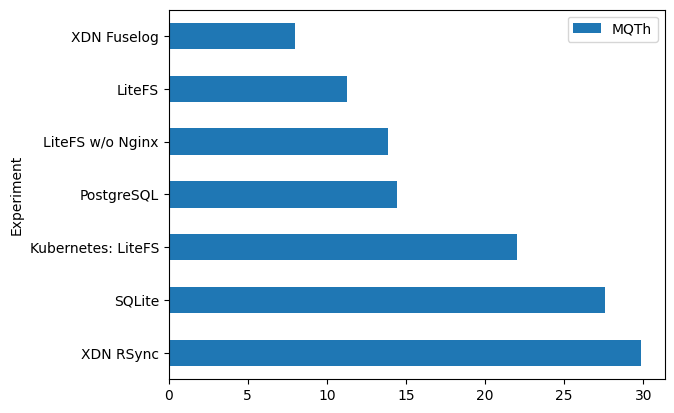

In [19]:
pd.read_csv('results/mqth.csv').plot.barh(x='Experiment', rot=0)